<a href="https://www.kaggle.com/code/quadeer15sh/word-pronunciation-generation-using-lstms?scriptVersionId=104585361" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [29]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Input, LSTM, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt 
import seaborn as sns 

plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['font.size'] = 16
sns.set_style('darkgrid')

# Word Pronunciations: Word to Phoneme Conversion

<div class='alert alert-info'><strong>Phoneme Conversion:</strong> Converts lexical orthographic symbols (words) to phonetic representation along with other possible information such as stress placement.</div>

__Phoneme Conversion__
- Words to phonemes converters can help you figure out how to pronounce a certain word. e.g. Google word pronunication utility
- Conversion of words to phonemes is an important step in the process of Text-to-Speech synthesis, where a system is given an input text which is preprocessed through various stages to identify how a text sentence needs to be spoken out loud by identifying the pronunciations and prosody of each word present in the sentence. 

__Encoder-Decoder Architecture__
- This type of architecture can be used for solving Sequence to Sequence problems aka Seq2Seq
- Seq2Seq encoder decoder architectures can be constructed using the Recurrent Neural Networks (RNNs) (Transformers being a more popular choice these days)
- LSTM, which is a variant of RNN, will be used in this kernel
- This architecture is comprised of two models: one for reading the input sequence and encoding it into a fixed-length vector, and a second for decoding the fixed-length vector and outputting the predicted sequence.
- We can formulate the problem of word to phoneme conversion in the same way, where the words are tokenized at a character level and passed as an input sequence of fixed length to the encoder, and the decoder is supposed to predict the output sequence of phonemes.
- This kind of architecture is/was (Transformers have overtaken) typically used in language translation models, where a sentence in one language is passed as an input sequence to the decoder and the encoder predicts the output sequence in the target language.

<img src='https://miro.medium.com/max/1400/1*1JcHGUU7rFgtXC_mydUA_Q.jpeg'>

# Data Preparation
- The pronunciations in this dictionary are annotated in ARPABET
- Each word is represented with a unique one or two letter code, with a space between each phoneme sound
- Stress is indicated by a digit immediately following a vowel.
    - 0: No Stress
    - 1: Primary Stress
    - 2: Secondary Stress
- Stressed vowel sounds are longer, louder, and/or higher in pitch than vowel sounds without stress

In [2]:
words = []
phonics_list = []
dict_file = open('../input/cmu-pronouncing-dictionary/cmudict.dict', 'r')
with dict_file as f:
    phonics = [line.rstrip('\n') for line in f]
    for p in phonics:
        x = p.split(' ')
        words.append(x[0])
        phonics_list.append(' '.join(x[1:]))
data = pd.DataFrame({'Word': words, 'Phonics': phonics_list})
data.head()

,Word,Phonics
0,'bout,B AW1 T
1,'cause,K AH0 Z
2,'course,K AO1 R S
3,'cuse,K Y UW1 Z
4,'em,AH0 M


## Sampling: Taking 100000 Random Samples from the data
- The train and test set will be split using these 100000 samples

In [3]:
df = data.sample(100000).reset_index(drop=True)
df

,Word,Phonics
0,scantiness,S K AE1 N T IY0 N AH0 S
1,leathery,L EH1 DH ER0 IY0
2,dyestuffs,D AY1 S T AH2 F S
3,swirls,S W ER1 L Z
4,marring,M AA1 R IH0 NG
...,...,...
99995,wickets(2),HH W IH1 K AH0 T S
99996,mckinley,M AH0 K IH1 N L IY0
99997,claudine,K L AO0 D IY1 N
99998,climatic,K L AY0 M AE1 T IH0 K


<div class='alert alert-warning'><strong>Note:</strong> Some of these words contain special characters and numbers in round brackets. The numbers indicate an alternative variation of the word. Special characters are present to denote different expressions. So since these characters have a certain meaning, the words containing them won't be deleted.</div>

In [4]:
df[~df['Word'].apply(lambda x: x.isalnum())]

,Word,Phonics
10,grandbaby(2),G R AE1 N B EY2 B IY0
17,weirton's,W IH1 R T AH0 N Z
32,sadat's,S AA0 D AA1 T S
35,food's,F UW1 D Z
37,rhinoplasty(2),R IH2 N OW0 P L AE1 S T IY2
...,...,...
99961,sampras's,S AE1 M P R AH0 S IH0 Z
99966,concord's,K AA1 N K AO2 R D Z
99977,ross's,R AA1 S IH0 Z
99981,calite(2),K EY1 L AY2 T


# Preprocessing

## Phonics Preprocessing
- __startseq__ and __endseq__ tags are added at the beginning and the end of the phonics to indicate when they shall begin and end while decoding
- An example of how these tags are used in Sequence to Sequence problems is given below

<img src='https://edumunozsala.github.io/BlogEms/images/copied_from_nb/images/encoder_decoder_basic.png'>

In [5]:
df['Phonics'] = 'startseq '+df['Phonics']+' endseq'
df

,Word,Phonics
0,scantiness,startseq S K AE1 N T IY0 N AH0 S endseq
1,leathery,startseq L EH1 DH ER0 IY0 endseq
2,dyestuffs,startseq D AY1 S T AH2 F S endseq
3,swirls,startseq S W ER1 L Z endseq
4,marring,startseq M AA1 R IH0 NG endseq
...,...,...
99995,wickets(2),startseq HH W IH1 K AH0 T S endseq
99996,mckinley,startseq M AH0 K IH1 N L IY0 endseq
99997,claudine,startseq K L AO0 D IY1 N endseq
99998,climatic,startseq K L AY0 M AE1 T IH0 K endseq


## Maximum Number of Characters in Words, and Phonemes in Phonics
- Max. number of characters will be more than 26 letters as there are some important special characters also present
- Max. number of phonemes will depend on the number of unique codes present in the phonics corpus

In [6]:
max_len_ip = df['Word'].apply(lambda x: len(x)).max()
max_len_op = df['Phonics'].apply(lambda x: len(x.split())).max()

In [7]:
words = df['Word'].tolist()
phonemes = df['Phonics'].tolist()

## Tokenization

<div class='alert alert-info'><strong>Tokenization: </strong>Tokenization is nothing but splitting the raw text into small chunks of words or sentences, called tokens. In case of tokenization of words, it simply means to split them into characters.</div>

The words and phonics need to be converted into some encodings which can be passed to the LSTM encoder-decoder architecture while training, therefore we need to perform tokenization on both the input as well as the output
- Character level tokenization of input words
- Word level tokenization of output sequences

An example of different types of tokenization is given below

<img src='https://miro.medium.com/max/1400/1*RcSo3UpBTorMI6YJvVizSg.jpeg'>

In [8]:
char_tokenizer = Tokenizer(char_level=True,oov_token='OOV')
char_tokenizer.fit_on_texts(words)
char_vocab_size = len(char_tokenizer.word_index) + 1
print("Character Vocab Size: ",char_vocab_size)

phone_tokenizer = Tokenizer(oov_token='OOV')
phone_tokenizer.fit_on_texts(phonemes)
phone_vocab_size = len(phone_tokenizer.word_index) + 1
print("Phoneme Vocab Size: ",phone_vocab_size)

Character Vocab Size:  37
Phoneme Vocab Size:  77


In [9]:
ch_sequences = char_tokenizer.texts_to_sequences(words)
ph_sequences = phone_tokenizer.texts_to_sequences(phonemes)

In [10]:
print("Phoneme: ", phonemes[2])
print("Phonic Sequence: ",ph_sequences[2])

Phoneme:  startseq D AY1 S T AH2 F S endseq
Phonic Sequence:  [2, 11, 35, 6, 8, 61, 23, 6, 3]


## Phoneme Sequence Generation Preprocessing
- The output phonetic sequence needs to be preprocessed in a way such that everytime the decoder is fed the encoded information (encoder output) of the sequence of characters passed to it along with the startseq tag (to indicate the beginning of the phoneme sequence) it should be able to predict the next phoneme in the sequence.
- An example is given in the table below

| Sentence | Tokenized Sequence |
| --- | --- |
| startseq | [2] |
| startseq M | [2, 13] |
| startseq M AH0 | [2, 13, 4] |
| startseq M AH0 G | [2, 13, 4, 24] |
| startseq M AH0 G IH1 | [2, 13, 4, 24, 22] |
| startseq M AH0 G IH1 L | [2, 13, 4, 24, 22, 7] |
| startseq M AH0 G IH1 L endseq | [2, 13, 4, 24, 22, 7, 3] |

- The input and output vector encoded representations are padded with zeros to match the longest sequence present in the input and output respectively. Instead of choosing the longest possible record present in the data one can choose another length of padding/shortening using some statistical technique or through EDA as well.

In [11]:
encoder_inputs = pad_sequences(ch_sequences, maxlen=max_len_ip, padding='post')

decoder_inputs = []
decoder_outputs = []

for ph in ph_sequences:
    decoder_inputs.append(ph[:-1])
    decoder_outputs.append(ph[1:])

decoder_inputs = pad_sequences(decoder_inputs, maxlen=max_len_op, padding='post')
decoder_outputs = pad_sequences(decoder_outputs, maxlen=max_len_op, padding='post')

# Modelling

## Train and Test Split
- 85% of the data will be used for training the LSTM
- 15% will be used for testing (here its basically a validation set, but since the test will not be carried out on a separate hold out set but rather on some of our custom inputs, we will just refer to this as test set)

In [12]:
n = len(words)
split_index = int(0.85 * n)

X_train = [encoder_inputs[:split_index], decoder_inputs[:split_index]]
y_train = decoder_outputs[:split_index]

X_test = words[split_index:]
y_test = phonemes[split_index:]

## Encoder-Decoder LSTM
- Encoder: Input of sequence of characters
- Decoder: Output of sequence of phones
<img src='https://i.imgur.com/vzkiAnZ.png'>

In [15]:
ch_vocab = 37
ph_vocab = 77

# Encoder
char_input = Input(shape=(None,))
x = Embedding(ch_vocab, 256, mask_zero=True)(char_input)
output_y, state_h, state_c = LSTM(256, return_state=True)(x)

# Decoder
ph_input = Input(shape=(None,))
embedding_layer = Embedding(ph_vocab, 256, mask_zero=True)
x = embedding_layer(ph_input)
decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
output_y, _ , _ = decoder_lstm(x, initial_state=[state_h, state_c])
softmax_dense = Dense(ph_vocab, activation='softmax')
output = softmax_dense(output_y)

model = Model(inputs=[char_input, ph_input],outputs=output)
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 256)    9472        input_3[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 256)    19712       input_4[0][0]                    
____________________________________________________________________________________________

In [16]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 3, verbose = 1, restore_best_weights=True)

In [17]:
history = model.fit(X_train,y_train,
                    batch_size=32,
                    epochs=20,
                    validation_split=0.10,
                    validation_batch_size=32,
                    callbacks=[checkpoint,earlystopping])

2022-08-31 08:00:48.830254: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-08-31 08:00:56.420547: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


2391/2391 [==============================] - 45s 15ms/step - loss: 0.2783 - val_loss: 0.1404

Epoch 00001: val_loss improved from inf to 0.14044, saving model to model.h5
Epoch 2/20
2391/2391 [==============================] - 32s 14ms/step - loss: 0.1144 - val_loss: 0.1024

Epoch 00002: val_loss improved from 0.14044 to 0.10235, saving model to model.h5
Epoch 3/20
2391/2391 [==============================] - 33s 14ms/step - loss: 0.0873 - val_loss: 0.0897

Epoch 00003: val_loss improved from 0.10235 to 0.08965, saving model to model.h5
Epoch 4/20
2391/2391 [==============================] - 33s 14ms/step - loss: 0.0735 - val_loss: 0.0847

Epoch 00004: val_loss improved from 0.08965 to 0.08471, saving model to model.h5
Epoch 5/20
2391/2391 [==============================] - 33s 14ms/step - loss: 0.0638 - val_loss: 0.0817

Epoch 00005: val_loss improved from 0.08471 to 0.08166, saving model to model.h5
Epoch 6/20
2391/2391 [==============================] - 33s 14ms/step - loss: 0.0560 

# Model Inference

## Learning Curve
- The model has overfit slightly, lets look at the inferences on the custom inputs

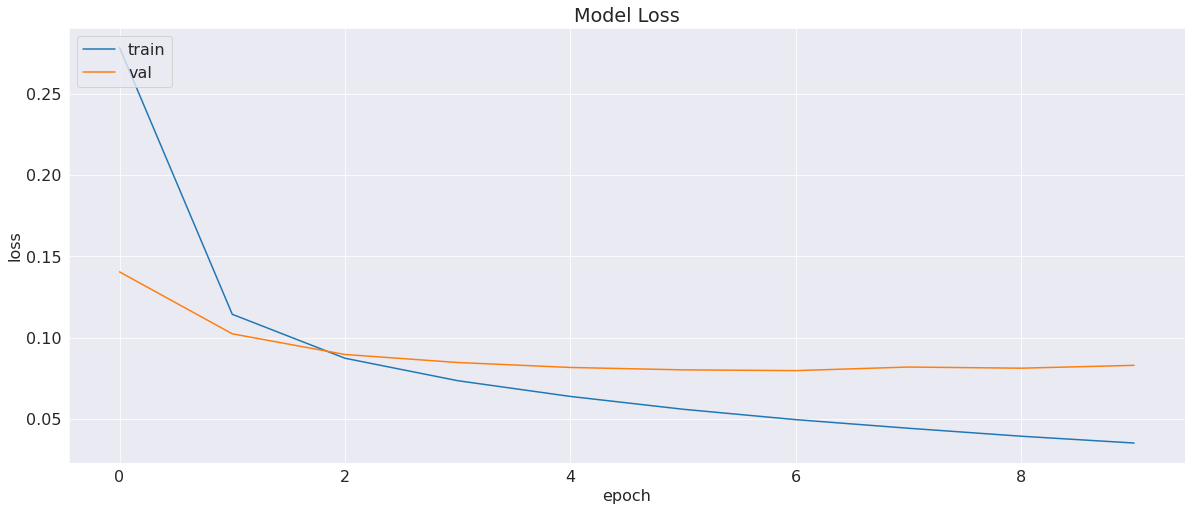

In [33]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Inference Model: Using Trained Weights

<div class='alert alert-warning'><strong>Note: </strong>This is a reconstruction of the model trained earlier so that we can run inferences on our custom inputs. So this is not a new model that is being built. The idea is to use the parameters found during the training process and use them during our inference stage.</div>

- First the hidden and cell state information of the encoder LSTM needs to be generated
- The hidden and cell state information is passed on to the decoder along with phonemes generated at each step of inference

A generic neural machine translation model illustration is given below to give an idea of how encoder-decoder architectures work during the inference stage. In case of word to phoneme conversion, the characters of the word will be passed and the decoder will produce a sequence of phonemes at each step of generation until the endseq tag is encountered.

<img src='https://cdn.analyticsvidhya.com/wp-content/uploads/2019/06/seq2seq.gif'>

In [18]:
encoder = Model(char_input, [state_h, state_c])

#Decoder
decoder_input_h = Input(shape=(256,))
decoder_input_c = Input(shape=(256,))
x = embedding_layer(ph_input)
x, decoder_output_h, decoder_output_c = decoder_lstm(x, initial_state=[decoder_input_h, decoder_input_c])
x = softmax_dense(x)
decoder = Model([ph_input] + [decoder_input_h, decoder_input_c], 
                                [x] + [decoder_output_h, decoder_output_c])

## Phoneme Generation
- After passing the complete cell state and hidden state information of the encoder, the starseq token is first passed to the decoder along will the state information which produces the next phoneme token.
- Each of these phoneme tokens are then added to the sequential input to generate the subsequent phoneme tokens. 

In [19]:
def predict_pronunciation(ch_input):
    input_seq = char_tokenizer.texts_to_sequences([ch_input])

    next_h, next_c = encoder.predict(input_seq)

    curr_token = np.zeros(1)
    curr_token[0] = phone_tokenizer.word_index['startseq']

    pred_sentence = ''

    for i in range(max_len_op):
        output, next_h, next_c = decoder.predict([curr_token] + [next_h, next_c])
        next_token = np.argmax(output[0, 0, :])
        next_word = phone_tokenizer.index_word[next_token]
        if next_word == 'endseq':
            break
        else:
            pred_sentence += ' ' + next_word
            curr_token[0] = next_token

    return pred_sentence

## Custom Inputs
- I have used random words for custome input (both dictionary and non-dictionary words)
- Some of these are human names and pokemon names

In [41]:
words = ['helds','cardholder','quadeer','kaadir','laughed','kritika','salamance','christopher',
         'ankita','garchomp','absol','gliscor','aayusmaan','sesquepedalian','crying',
         'backstabbing','pooja','kashish','ankoos','strong','originate']

for word in words:
    phoneme = predict_pronunciation(word)
    print(f"Word: {word}, Phoneme: {phoneme}\n")

Word: helds, Phoneme:  hh eh1 l d z

Word: cardholder, Phoneme:  k aa1 r d hh ow2 l d er0

Word: quadeer, Phoneme:  k w aa0 d ih1 r

Word: kaadir, Phoneme:  k aa1 d er0

Word: laughed, Phoneme:  l aa1 f t

Word: kritika, Phoneme:  k r ih0 t iy1 k ah0

Word: salamance, Phoneme:  s ae1 l ah0 m ae2 n s

Word: christopher, Phoneme:  k r ih1 s t ah0 f er0

Word: ankita, Phoneme:  aa0 ng k iy1 t ah0

Word: garchomp, Phoneme:  g aa1 r k ah0 m p

Word: absol, Phoneme:  ae1 b s ah0 l

Word: gliscor, Phoneme:  g l ih1 s k ao2 r

Word: aayusmaan, Phoneme:  ay1 ah0 s m ah0 n

Word: sesquepedalian, Phoneme:  s eh2 s k w ih0 p y uw2 l eh1 d ah0 n

Word: crying, Phoneme:  k r ay1 ih0 ng

Word: backstabbing, Phoneme:  b ae1 k s t ae2 b ih0 ng

Word: pooja, Phoneme:  p uw1 jh ah0

Word: kashish, Phoneme:  k ae1 sh ih0 sh

Word: ankoos, Phoneme:  ae0 ng k uw1 z

Word: strong, Phoneme:  s t r ao1 ng

Word: originate, Phoneme:  er0 ih1 jh ah0 n ey2 t



<div class='alert alert-success' style='font-size: 14px'>
    <strong>Conclusion:</strong>
    <li>The results are really accurate, and considering the fact that the model is doing well on the non-dictionary words as well is just remarkable.</li>
    <li>Since these are just word level conversions into their respective phonemes/pronunciations we do not really require attention models, as the input sequence length is really short.</li>
    <li>However, one can build the phoneme conversion model on an entire sentence input as well, as longer sentences might require attention based models to identify how a specific word in a sentence needs to be pronounced.</li>
</div>